## RNA FISH analysis / Spot Calling with BigFISH
[Documentation](https://big-fish.readthedocs.io/en/stable/index.html)

In [190]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyo
from PIL import Image
import io
import base64
# Image maniuplation
from skimage.segmentation import expand_labels
# BigFISH modules
import bigfish.stack as stack
import bigfish.multistack as multistack
import bigfish.detection as detection
import bigfish.plot as plot

In [191]:
### Function to apply the cell mask to the called spots
def apply_mask(spots, mask):
    """
    Filter spots (z, y, x) to keep only those that fall inside mask regions
    Parameters:
        spots - array with shape (z,y,x) or (y,x); spots detected from image
        mask - array with shape equal to that of image; masks cells from background
    """
    # Extract coordinates
    z = spots[:, 0]
    y = spots[:, 1].astype(int)
    x = spots[:, 2].astype(int)

    # Only keep spots within the image bounds
    in_bounds = ((y >= 0) & (y < mask.shape[0]) & (x >= 0) & (x < mask.shape[1]))

    # Filter 
    z = z[in_bounds]
    y = y[in_bounds]
    x = x[in_bounds]

    # Get mask label for each spot
    labels = np.array([mask[yy, xx] for yy, xx in zip(y, x)])
    print(labels)
    # Filter for spots inside a labeled cell (mask > 0)
    keep = labels > 0
    
    # Return filtered array
    return np.stack([z[keep], y[keep], x[keep]], axis=1)

### Define parameters & read images

In [192]:
##### Define some parameters
img_dir = "/mnt/data2/noah/fish_image/images_zStack/" # Directory of images
mask_dir = "/mnt/data2/noah/fish_image/images_mask/" # Directory of binary mask images
fovs = [f"{i:02}" for i in range(1, 43)]  # FOV keys, 1 through 42 for our data
channels = ["DAPI", "Cy3", "A647"] # Channels used, 3 in our data

##### Make recipe for image I/O (for now just use FOV 01 as an example)
recipe = {
    "fov": "42",
    "c": channels,
    "opt": "Location",
    "ext": "tif",
    "pattern": "opt_fov_c.ext"}
print(fovs)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42']


In [193]:
##### Load in the image as a stack
img = multistack.build_stack(recipe, input_folder=img_dir) # Shape = (round, channel, z, y, x)
print(f"Image shape: {img.shape}")

Image shape: (1, 3, 30, 1843, 1843)


### Spot detection

In [197]:
sizes = np.arange(150, 1650, 150)
sizes

array([ 150,  300,  450,  600,  750,  900, 1050, 1200, 1350, 1500])

In [199]:
num_spots.values()

dict_values([])

In [ ]:
##### Setup parameters for spot detection
calling_channel = "A647"
voxel_size = (100, 300, 300)     # Nanometer per voxel (z, y, x)
spot_radius = (150, 300, 300)    # Nanometer radii of spots (z, y, x)
mask_fname = "Mask_42_DAPI.tif"  # Full filename of corresponding FOV mask
mask_expand = 10                 # Euclidean distance in pixels by which to grow the masks. https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.expand_labels

##### Parameters exclusive to dense region decomposition
alpha = 0.5    # Intensity percentile used to compute reference spot [0,1]. Higher = brighter spots simulated in dense regions, but a high intensity score reduces number of spots added to dense region
beta = 1       # Multiplicative factor for intensity threshold. threshold = beta * max(median spot)
gamma = 3    # Multiplicative factor used to compute gaussian kernel size. kernel size = (gamma * spot radius) / voxel size. Higher = increases scale of gaussian filter and moothing the estimated background. To decompose very large bright areas, a large gamma should be chosen


# Subset channel to call dots on
dot_channel = img_rescaled[channels.index(calling_channel)]

In [214]:
dot_channel = stack.rescale(dot_channel, channel_to_stretch=0)

In [217]:
# Load mask
mask_path = os.path.join(mask_dir, mask_fname)
mask = stack.read_image(mask_path)

# Expand mask using a skimage function
mask = expand_labels(mask, distance=mask_expand)
print(mask.shape)

##### Initial spot detection
num_spots = {}

spots, thresh = detection.detect_spots(dot_channel,
                                           voxel_size=voxel_size,
                                           spot_radius=spot_radius, 
                                           return_threshold=True)


print(spots.shape)
#print(f"Detected {spots.shape[0]} spots before applying cell mask.")

(1843, 1843)
(4657, 3)


In [218]:
##### Dense Spot Decomposition
spots_post_decomposition, dense_regions, reference_spot = detection.decompose_dense(
        image=dot_channel, 
        spots=spots, 
        voxel_size=voxel_size, 
        spot_radius=spot_radius,  
        alpha=alpha,                     # alpha impacts the number of spots per candidate region
        beta=beta,                      # beta impacts the number of candidate regions to decompose
        gamma=gamma)                    # gamma the filtering step to denoise the image

In [219]:
##### Apply the cell mask to the caled spots; remove spots outside of masked regions
spots = apply_mask(spots_post_decomposition, mask)
print(f"Applied cell mask, {spots.shape[0]} spots remain.")

[  0   0   0 ...   0 151 151]
Applied cell mask, 5266 spots remain.


### Plot contrast
The below cell will take a couple seconds to run, but will produce side-by-side images of the channel used to call dots and one with the called dots overlaid.

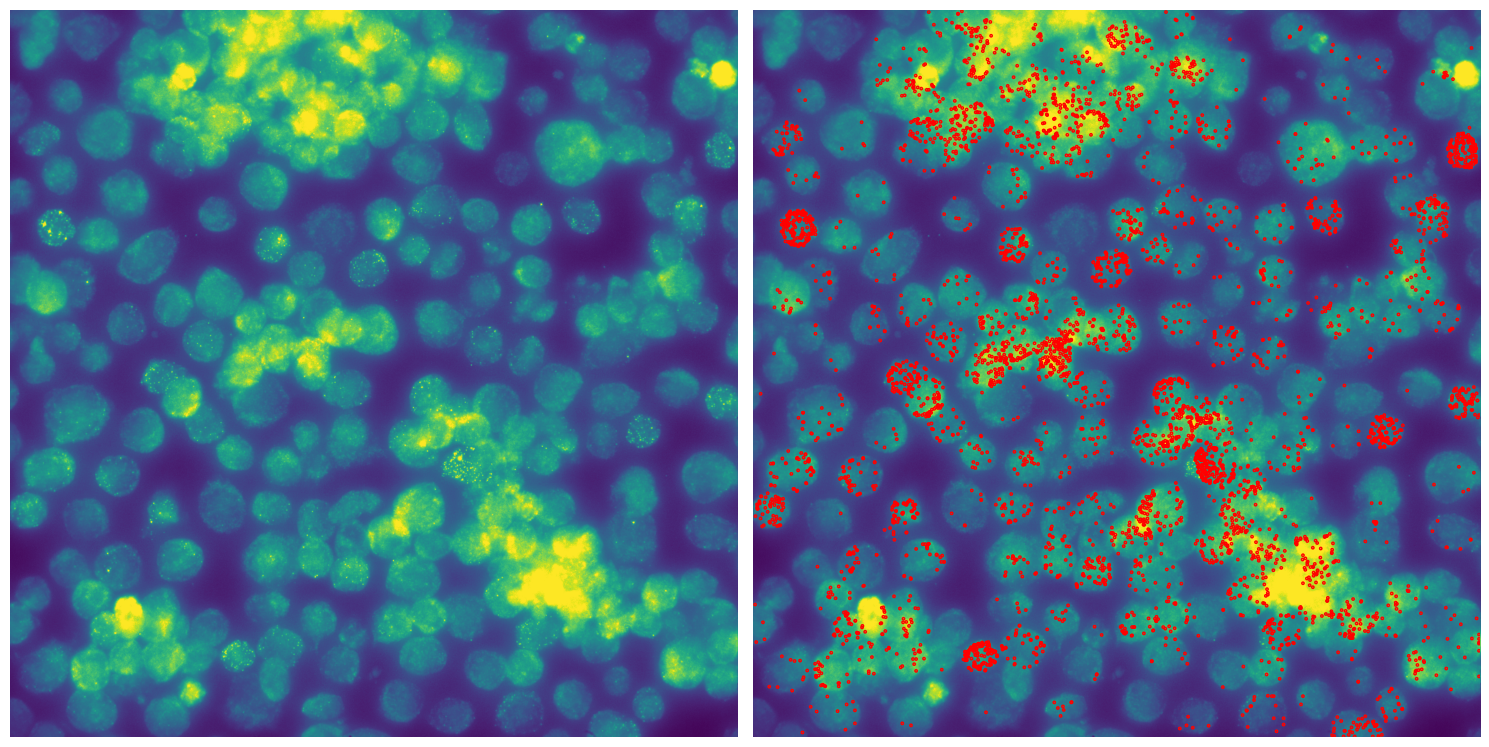

In [221]:
plot.plot_detection(stack.maximum_projection(dot_channel), spots, contrast=True)

### Interactive Plotting

In [223]:
# Normalize image
img_norm = np.clip(projection, np.percentile(projection, 1), np.percentile(projection, 99))
img_norm = ((img_norm - img_norm.min()) / (img_norm.max() - img_norm.min()) * 255).astype(np.uint8)

# Convert to PNG base64 string for plotly background
img_pil = Image.fromarray(img_norm)
buffer = io.BytesIO()
img_pil.save(buffer, format="PNG")
encoded_image = base64.b64encode(buffer.getvalue()).decode()

# Set up figure
fig = go.Figure()

# Add spots (x = col, y = row)
fig.add_trace(go.Scatter(
    x=spots[:, 2],
    y=spots[:, 1],
    mode='markers',
    marker=dict(size=4, color='red', symbol='circle-open', line=dict(width=0.5)),
    name='Spots'
))

# Set image background
fig.update_layout(
    images=[dict(
        source='data:image/png;base64,' + encoded_image,
        xref="x", yref="y",
        x=0, y=0,
        sizex=img_norm.shape[1], sizey=img_norm.shape[0],
        sizing="stretch",
        opacity=1,
        layer="below"
    )],
    yaxis=dict(scaleanchor="x", autorange='reversed'),
    xaxis=dict(showgrid=False),
    yaxis_showgrid=False,
    width=800,
    height=800,
    margin=dict(l=0, r=0, t=30, b=0),
    title=f"FOV 01 - {spots.shape[0]} Spots"
)

pyo.plot(fig, filename='temp_plot1.html', auto_open=True)

'temp_plot1.html'